# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [5]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [6]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


In [7]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [8]:
pb_dir_path = '../data/pseudobulks/'

In [9]:
os.listdir(pb_dir_path)

['pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [10]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [11]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

## Specie-specific genes

In [12]:
import pickle
with open("./results/specie_specific_genes_tr77.pkl", "rb") as file:
    genes_dict77 = pickle.load(file)

## Helpful functions

In [13]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [14]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [15]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [16]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [17]:
cs_genes = genes_dict77['chimp']

In [18]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_cs = df[cs_genes]

## Hierarchial

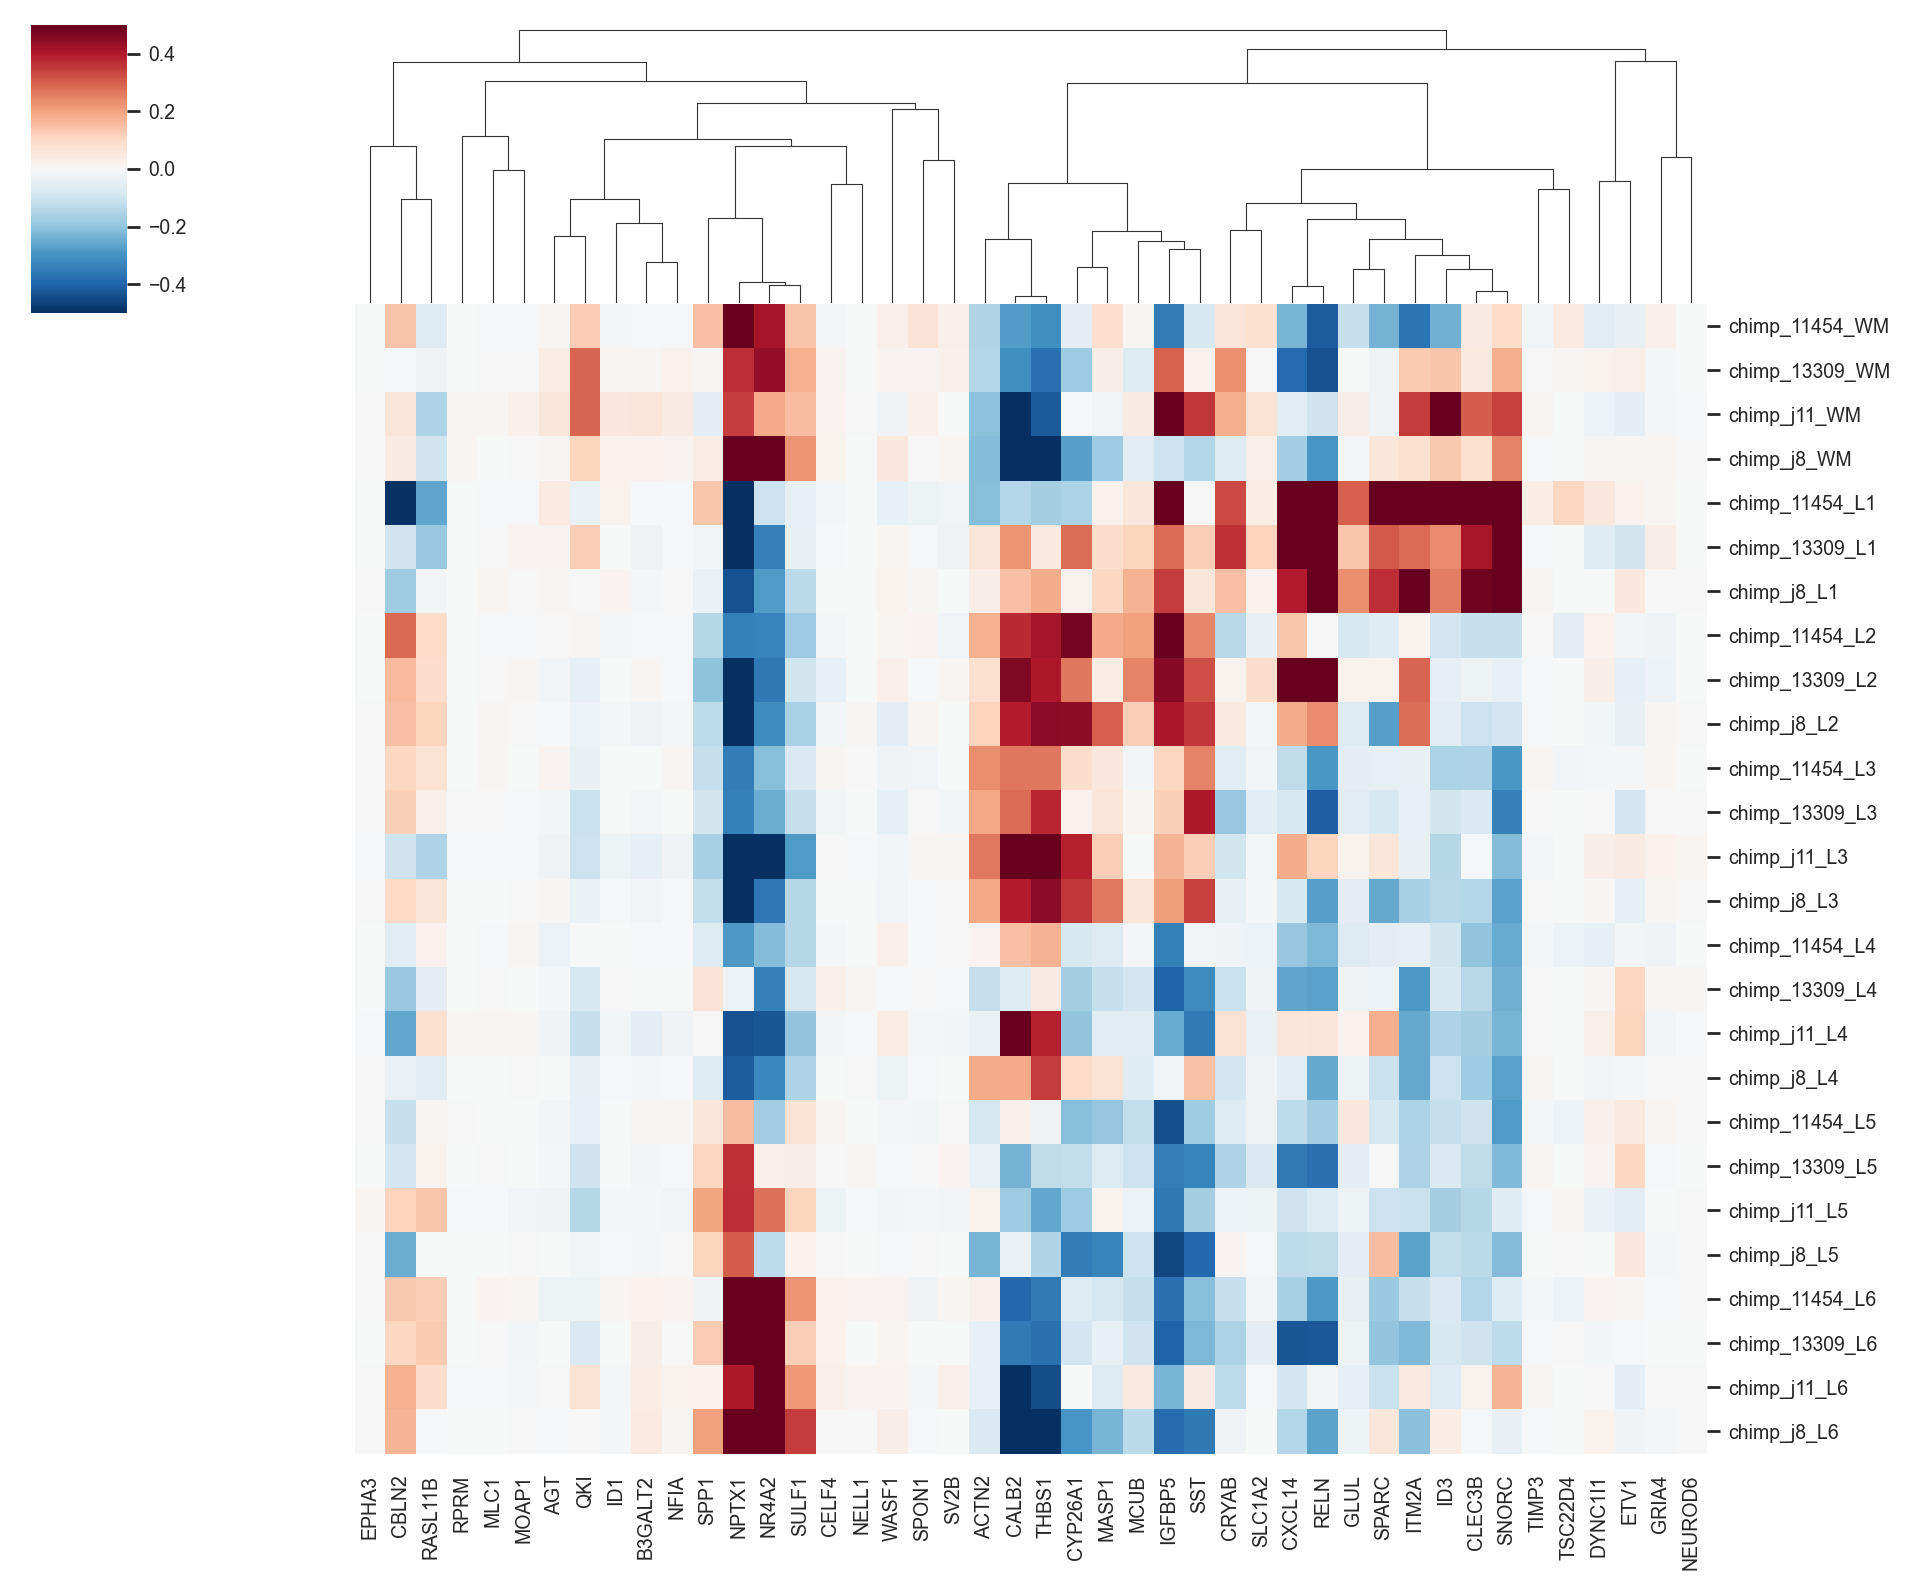

In [19]:
sns.set(font_scale=0.8)
sns.clustermap(df_cs.loc[sample_order['chimp']], figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.5, vmin=-0.5, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [20]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_cs.loc[sample_order['chimp']].T, metric='cosine') + 1
n_clusters = 2
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)

SpectralClustering(affinity='precomputed', gamma=1, n_clusters=2,
                   random_state=4)

In [21]:
labels = pd.Series(clustering.labels_, index=cs_genes).sort_values()
order = labels.sort_values().index

In [22]:
labels.to_csv('./results/chimp_clusters_77.csv')

In [23]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

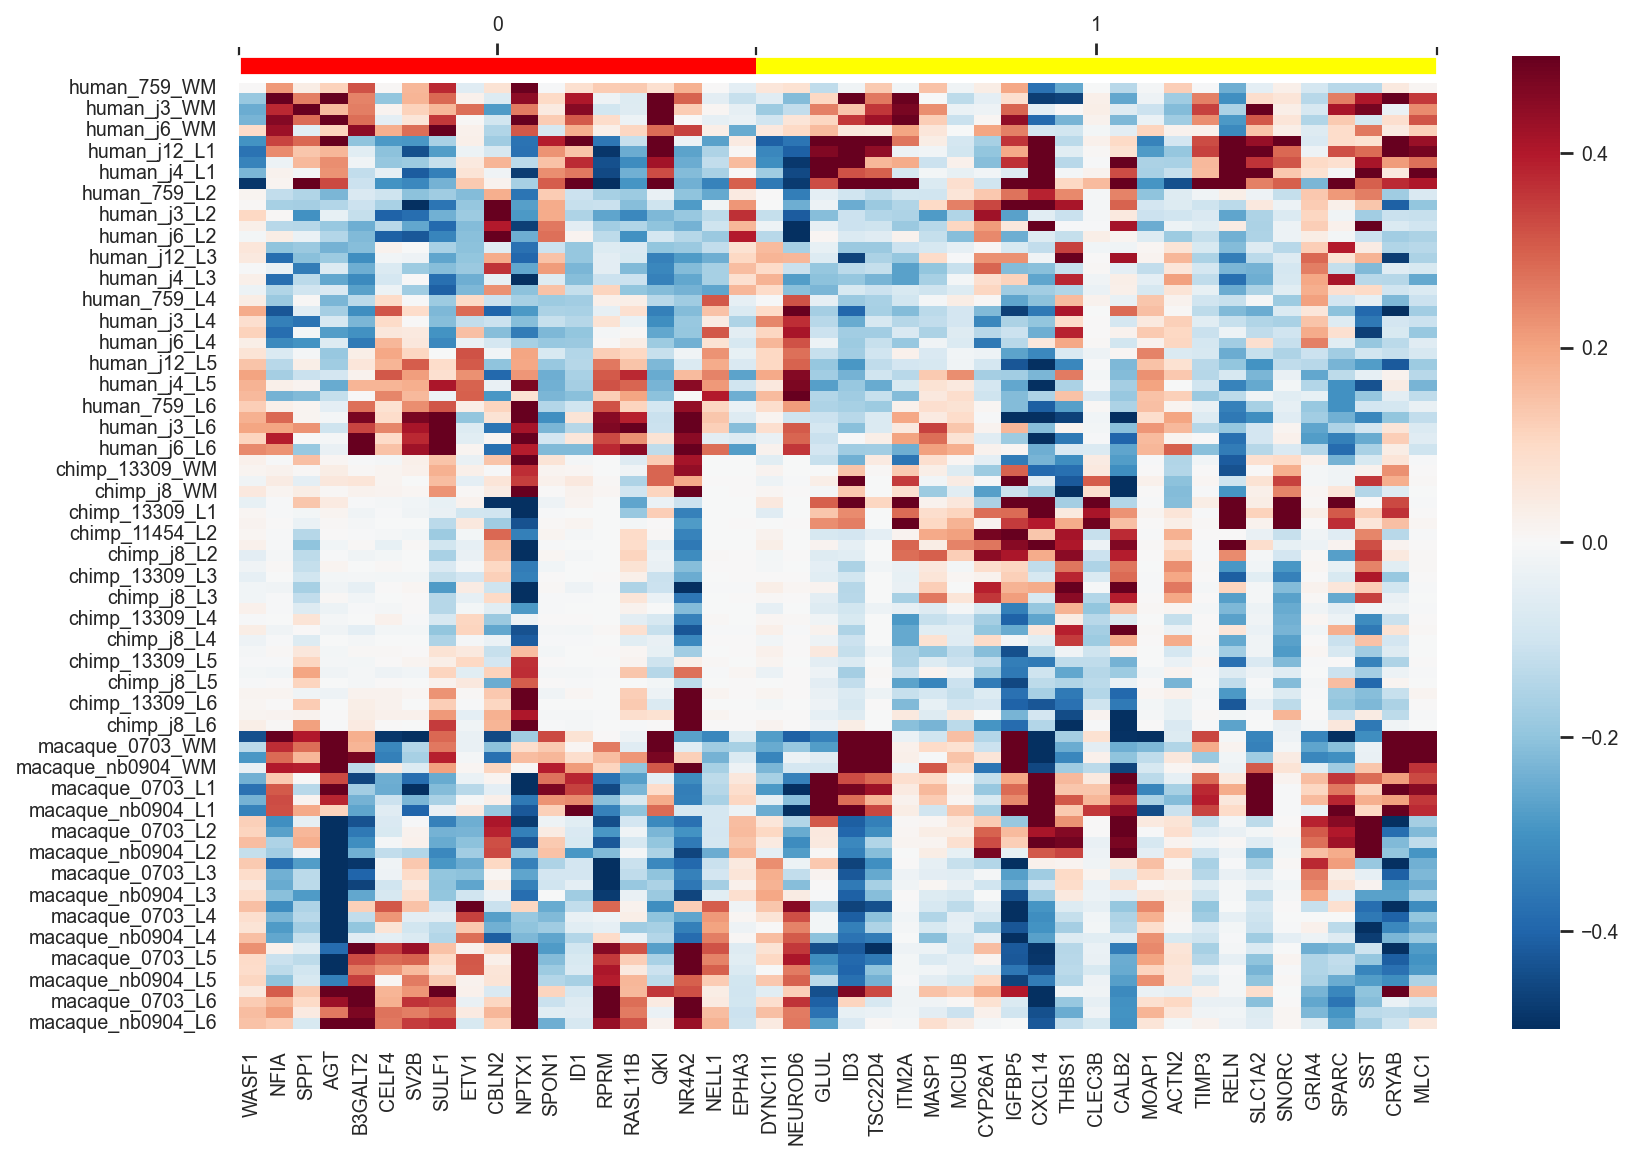

In [24]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_cs[order], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

## Cluster profiles

In [25]:
df_annotation = df_cs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [26]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ACTN2       AGT   B3GALT2     CALB2     CBLN2     CELF4  \
condition layer                                                               
chimp     L1    -0.037919  0.021529 -0.011758  0.076765 -0.257330 -0.005826   
          L2     0.125905 -0.007189 -0.007582  0.410350  0.197283 -0.020422   
          L3     0.220166 -0.003313 -0.017814  0.422841  0.055974 -0.001741   
          L4     0.011400 -0.015196 -0.015910  0.213624 -0.133812 -0.000294   
          L5    -0.084475 -0.011233 -0.005646 -0.105568 -0.085236 -0.005089   

                   CLEC3B     CRYAB    CXCL14   CYP26A1  ...     SPARC  \
condition layer                                          ...             
chimp     L1     0.525499  0.282525  0.564644  0.046873  ...  0.445502   
          L2    -0.081598 -0.024147  0.418961  0.397523  ... -0.105692   
          L3    -0.094402 -0.094649 -0.025732  0.212771  ... -0.079941   
          L4    -0.171405 -0.038620 -0.111744 -0.087944  ... -0.002207   
          L5    -0.126572 -0.057638 -0.179359 -0.216210  ... -0.008739   

                    SPON1      SPP1       SST     SULF1      SV2B     THBS1  \
condition layer                                                               
chimp     L1    -0.009143  0.030906  0.060971 -0.069200 -0.013757  0.020860   
          L2     0.005613 -0.157574  0.305595 -0.147644 -0.005658  0.423602   
          L3    -0.004785 -0.126055  0.278418 -0.155280 -0.000905  0.458362   
          L4    -0.004662 -0.015556 -0.134193 -0.144975 -0.005921  0.238344   
          L5    -0.005145  0.117140 -0.268711  0.059881 -0.001379 -0.139947   

                    TIMP3   TSC22D4     WASF1  
condition layer                                
chimp     L1     0.013124  0.035697 -0.005009  
          L2    -0.002590 -0.016834 -0.006282  
          L3    -0.000226 -0.005390 -0.025432  
          L4     0.000089 -0.008135  0.008728  
          L5    -0.001387 -0.004862 -0.008279  

[5 rows x 44 columns]

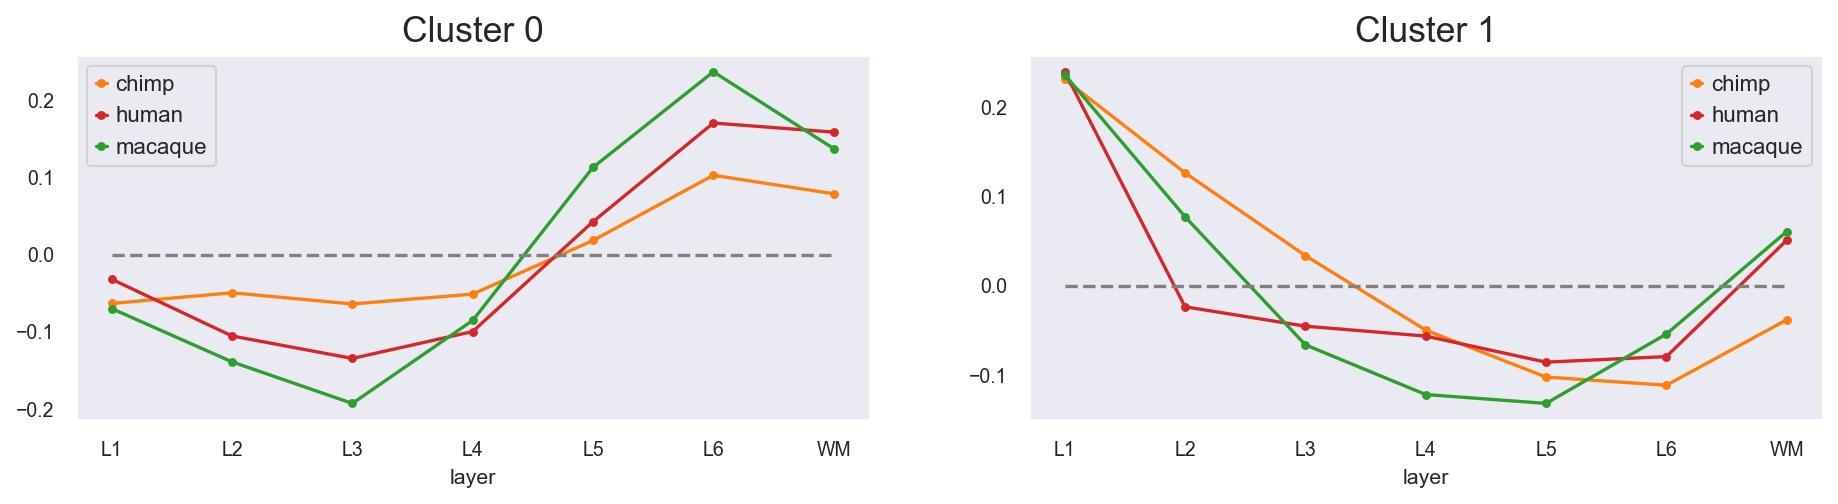

In [27]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

# Intersection with ANOVA clusters

In [28]:
anova_cs_inter = cs_genes.intersection(anova_labels.index)
anova_cs_inter

Index(['ACTN2', 'AGT', 'B3GALT2', 'CALB2', 'CBLN2', 'CELF4', 'CLEC3B', 'CRYAB',
       'CXCL14', 'CYP26A1', 'DYNC1I1', 'EPHA3', 'ETV1', 'GLUL', 'GRIA4', 'ID1',
       'ID3', 'IGFBP5', 'ITM2A', 'MASP1', 'MCUB', 'MLC1', 'MOAP1', 'NELL1',
       'NEUROD6', 'NFIA', 'NPTX1', 'NR4A2', 'QKI', 'RASL11B', 'RELN', 'RPRM',
       'SLC1A2', 'SNORC', 'SPARC', 'SPON1', 'SPP1', 'SST', 'SULF1', 'SV2B',
       'THBS1', 'TIMP3', 'TSC22D4', 'WASF1'],
      dtype='object')

In [29]:
table_to_pivot = pd.concat([anova_labels.loc[anova_cs_inter], labels.loc[anova_cs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels,0,1
ANOVA_labels,,
0,2.0,1.0
1,9.0,1.0
2,2.0,5.0
3,3.0,4.0
4,3.0,5.0
5,0.0,4.0
6,0.0,5.0


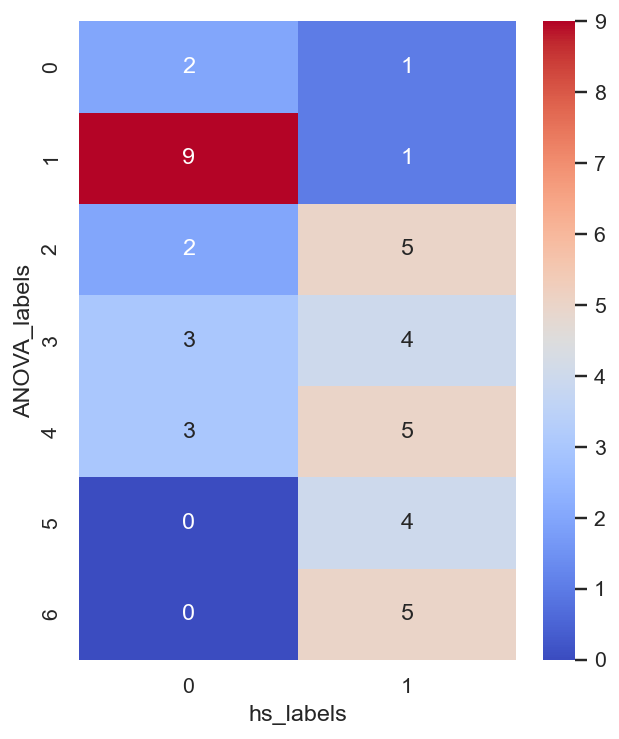

In [30]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

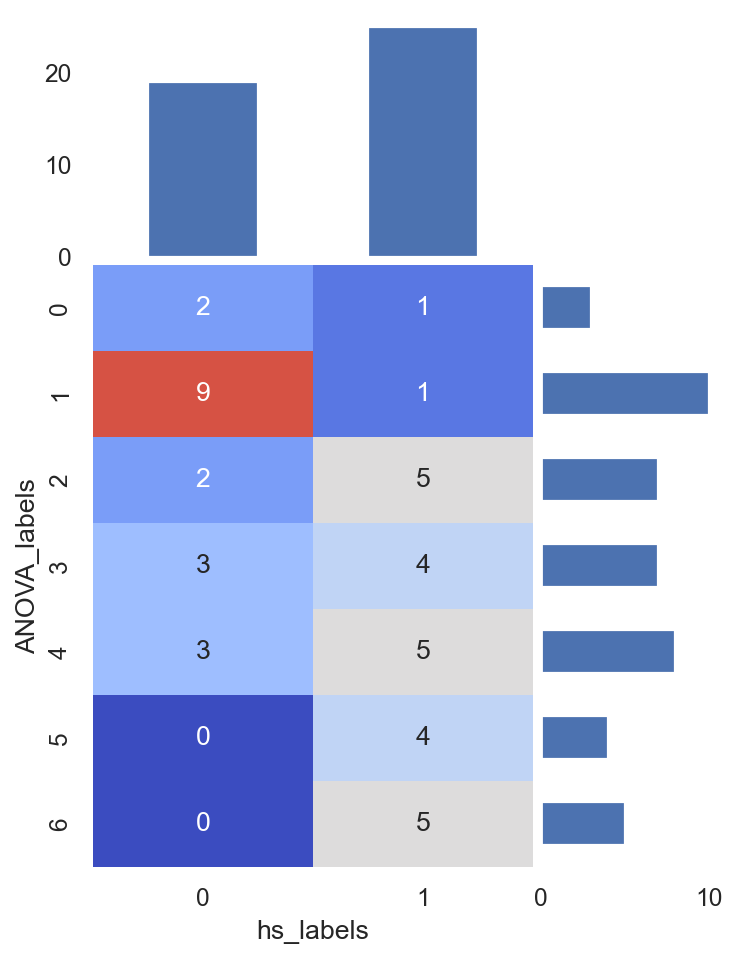

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', center=5, fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [32]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/2 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [33]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [34]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
renal system development (GO:0072001),1,0.001373,43.124706,284.223749,"[SULF1, AGT]",0.080106,0,0,2,1.096335,0
positive regulation of activation of Janus kinase activity (GO:0010536),2,0.002063,inf,inf,[AGT],0.080106,0,0,1,1.096335,0
low-density lipoprotein particle remodeling (GO:0034374),3,0.002063,inf,inf,[AGT],0.080106,0,0,1,1.096335,0
regulation of activation of Janus kinase activity (GO:0010533),4,0.002063,inf,inf,[AGT],0.080106,0,0,1,1.096335,0
negative regulation of morphogenesis of an epithelium (GO:1905331),5,0.002063,inf,inf,[SULF1],0.080106,0,0,1,1.096335,0


In [35]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

9

In [36]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

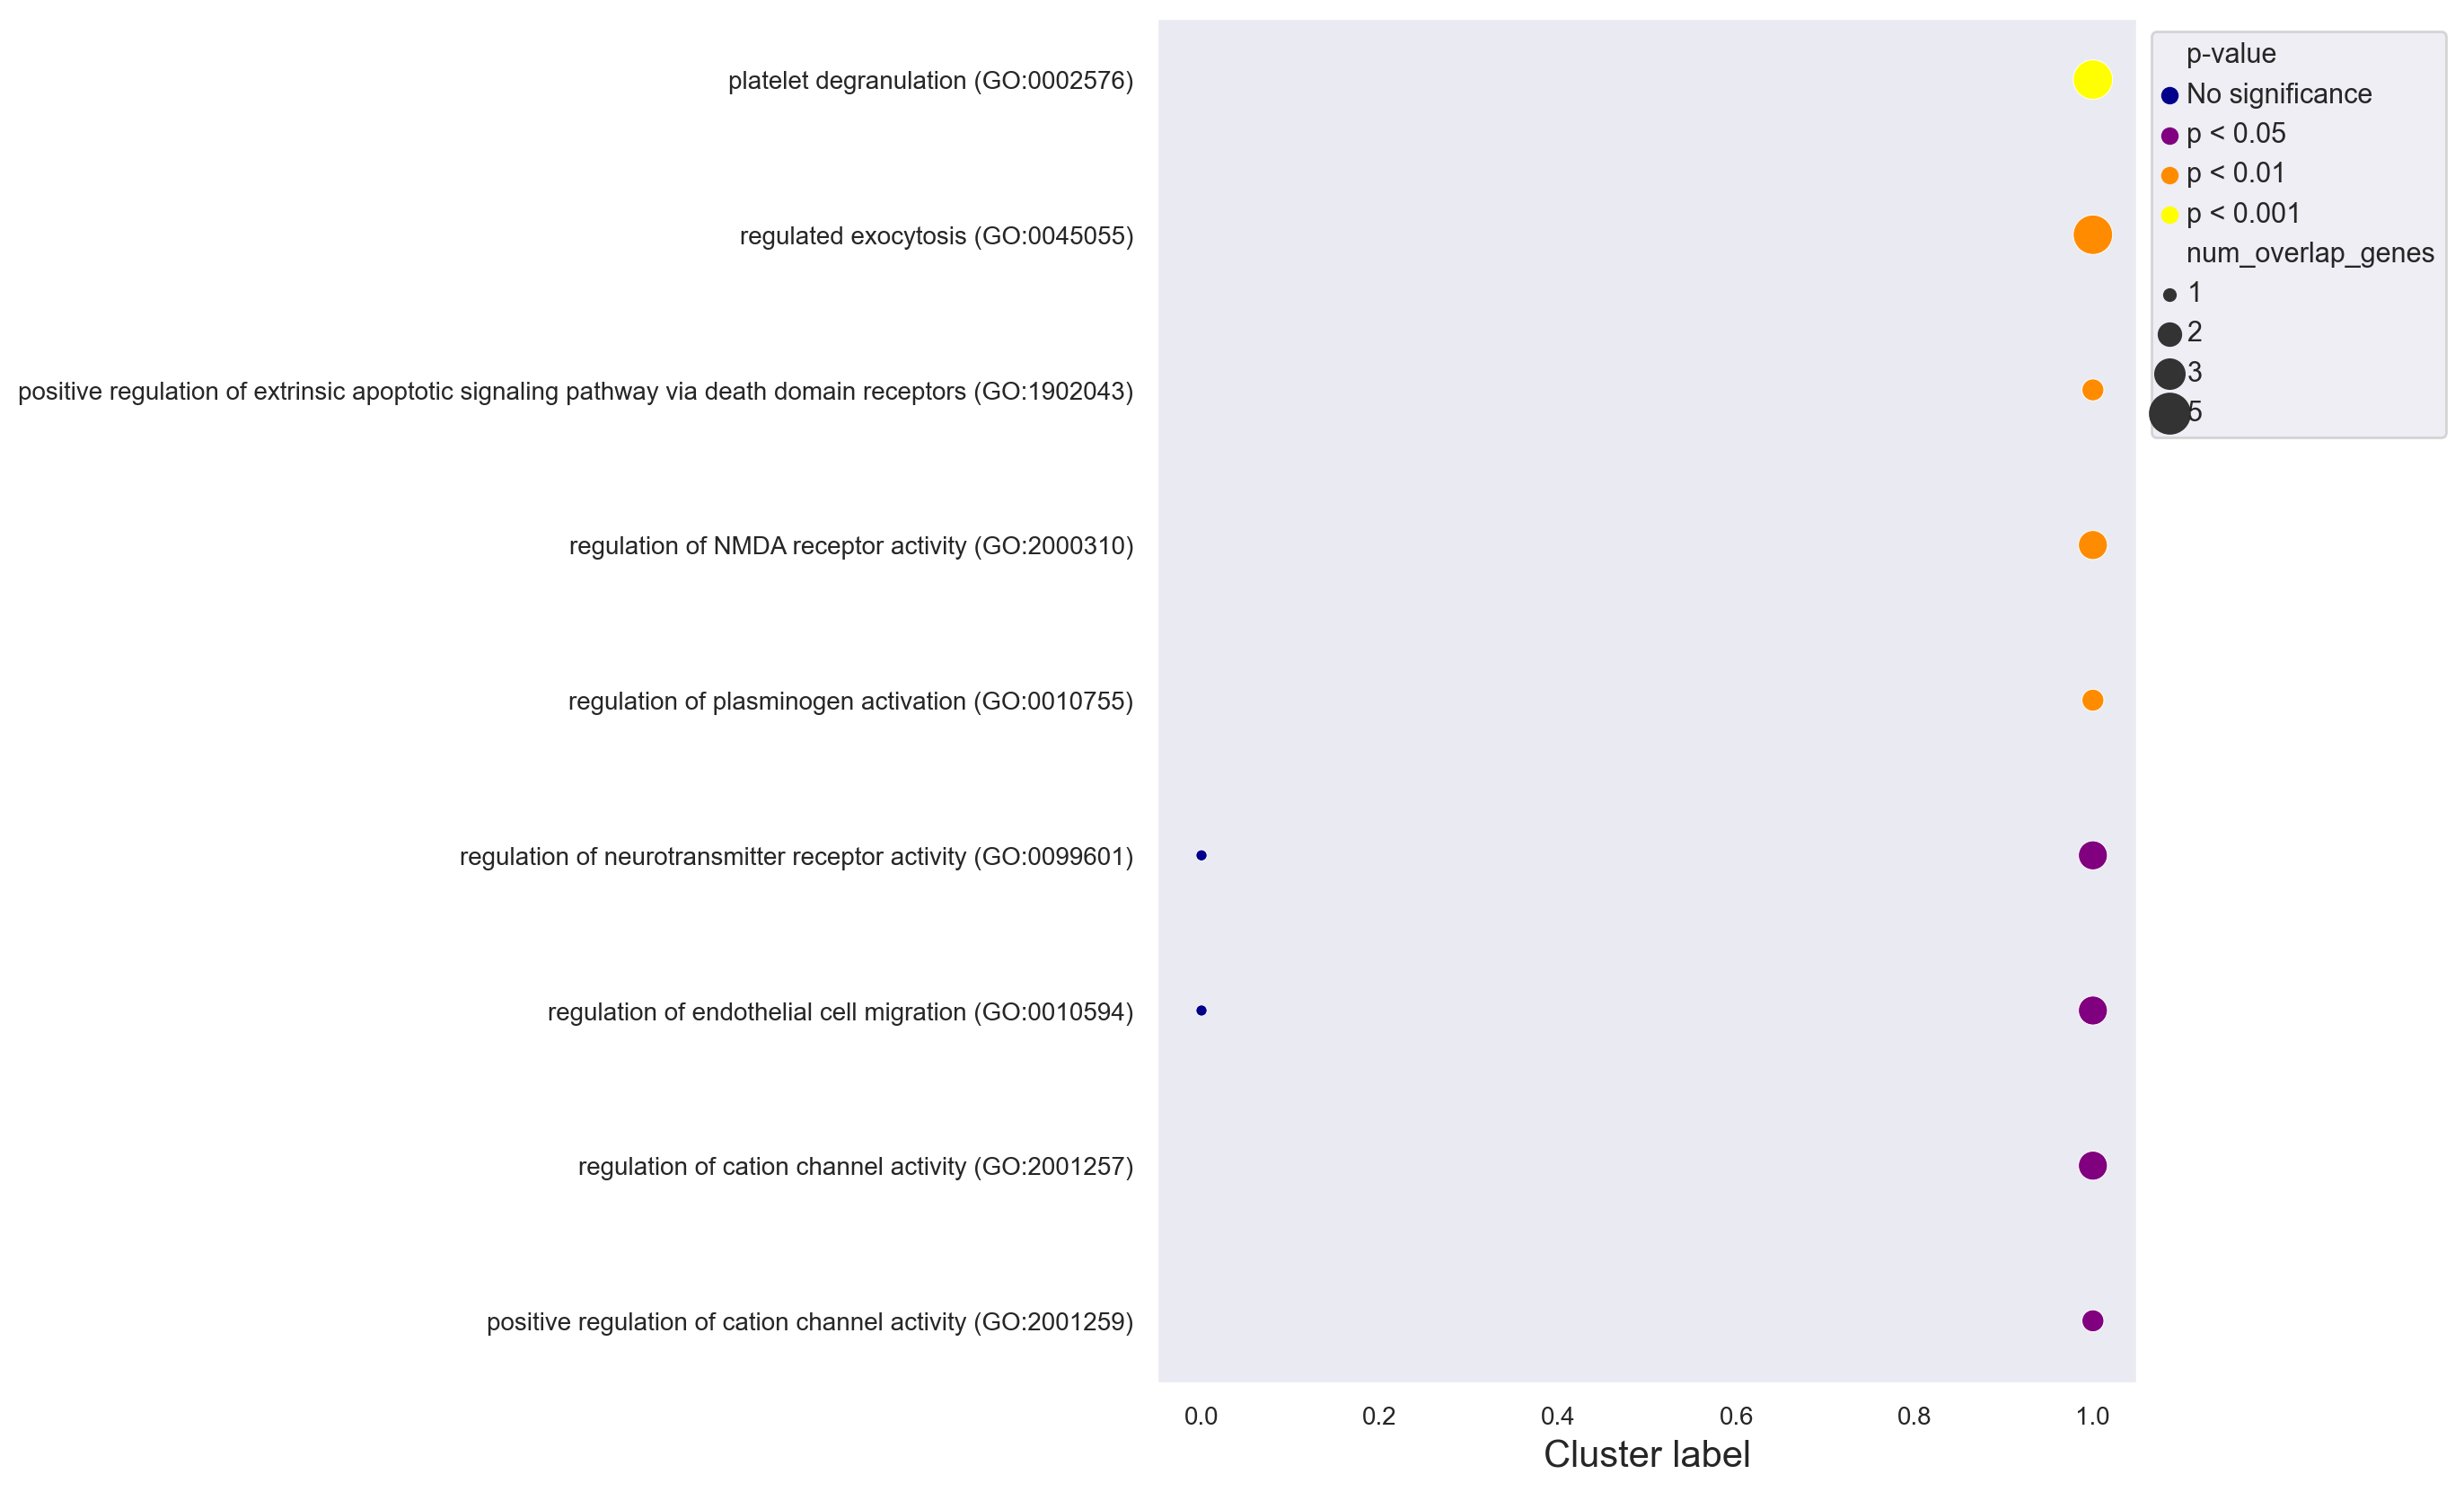

In [37]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [38]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [39]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
PVALB+ SAMD13+ Layer 3 GABAergic Neuron CL0000617,1,0.000112,180.058824,1637.808119,"[SULF1, EPHA3]",0.003139,0,0,2,2.503168,0
FEZF2+ CFTR+ Layer 5-6 Glutamatergic Neuron CL0000679,2,0.004123,510.444444,2802.970004,[NR4A2],0.017481,0,0,1,1.757434,0
"Layer 6 Glutamatergic Neuron, Intratelencephalon-Projecting 3 CL0000679",3,0.008229,170.111111,816.539964,[NR4A2],0.017481,0,0,1,1.757434,0
LINC00507+ DSG3+ Layer 2-3 Glutamatergic Neuron CL0000679,4,0.008229,170.111111,816.539964,[CBLN2],0.017481,0,0,1,1.757434,0
Gamma Islet Cell CL0002275,5,0.008229,170.111111,816.539964,[ETV1],0.017481,0,0,1,1.757434,0


In [40]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

18

In [41]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

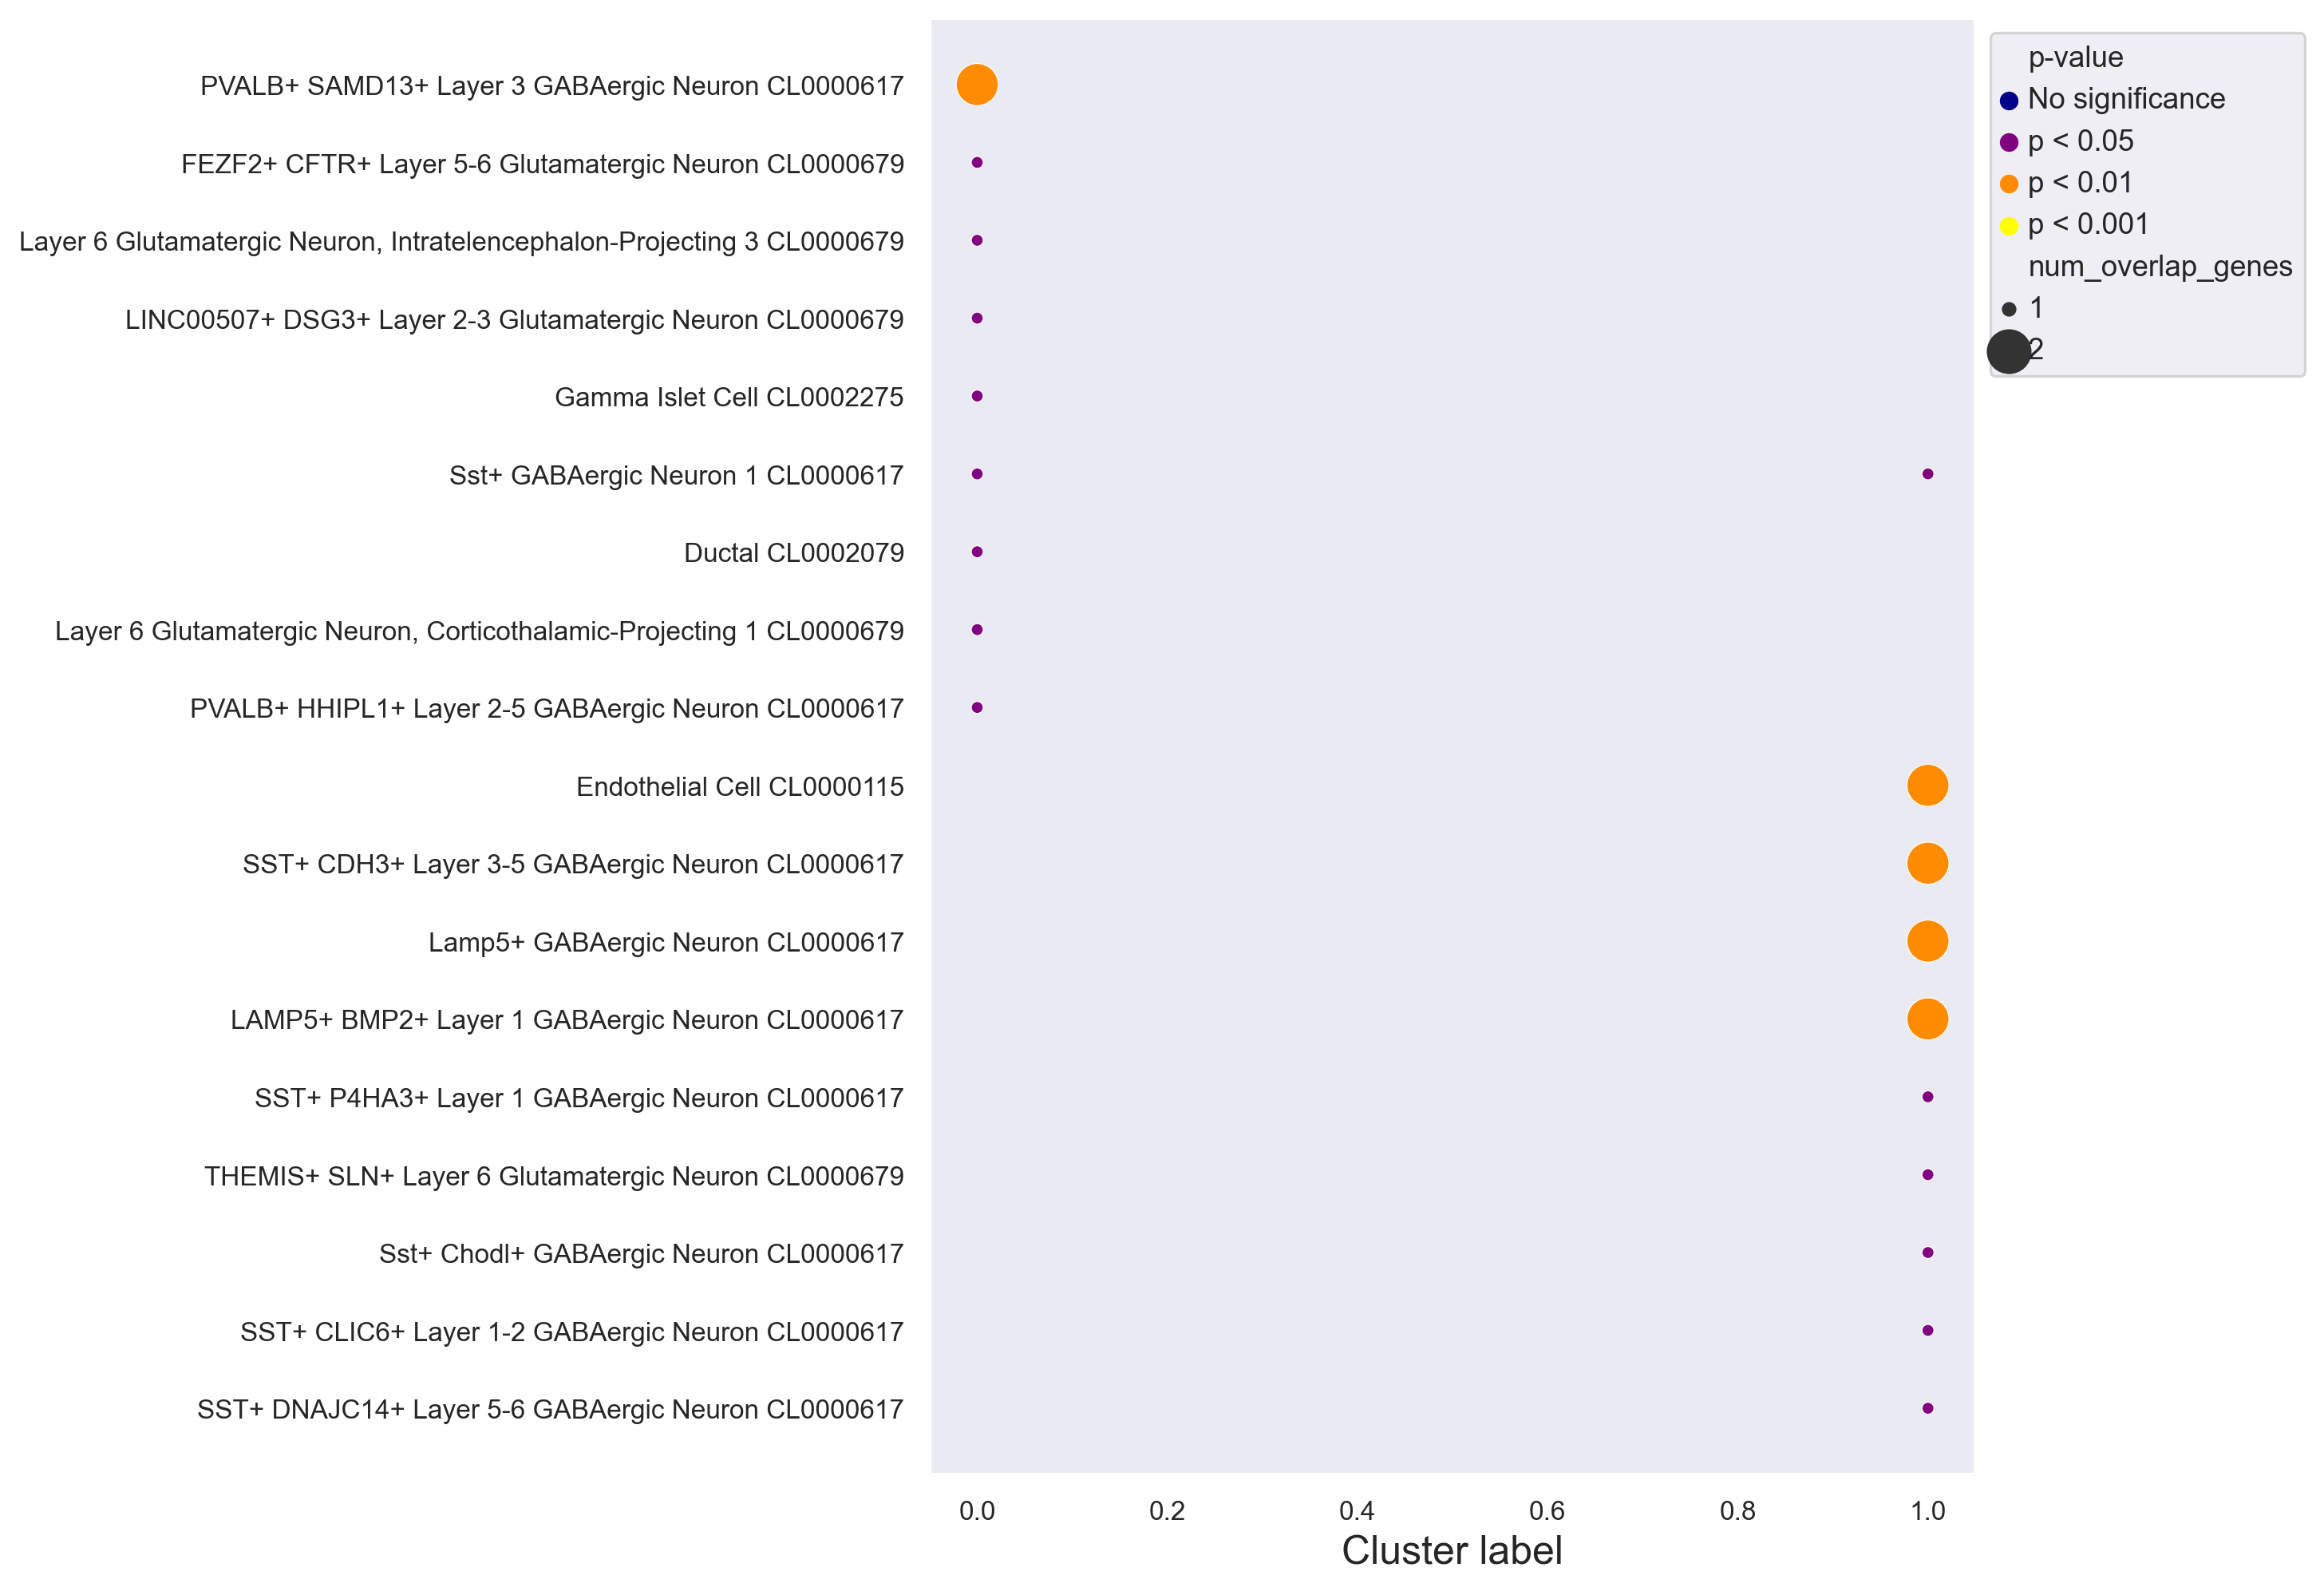

In [42]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [43]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [44]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
abnormal substantia nigra morphology MP:0000836,1,0.000024,540.411765,5745.384810,"[NR4A2, SPP1]",0.006181,0,0,2,2.208967,0
decreased body size MP:0001265,2,0.000032,10.583854,109.532567,"[SV2B, NFIA, ID1, CELF4, ETV1, WASF1, AGT]",0.006181,0,0,7,2.208967,0
dilated renal tubules MP:0002705,3,0.000065,47.671875,459.644304,"[NFIA, SPP1, AGT]",0.008124,0,0,3,2.090204,0
decreased urine sodium level MP:0006317,4,0.000084,216.094118,2027.484611,"[SPP1, AGT]",0.008124,0,0,2,2.090204,0
decreased systemic arterial systolic blood pressure MP:0006264,5,0.000310,98.160428,792.901116,"[SPP1, AGT]",0.019953,0,0,2,1.699991,0


In [45]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

15

In [46]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

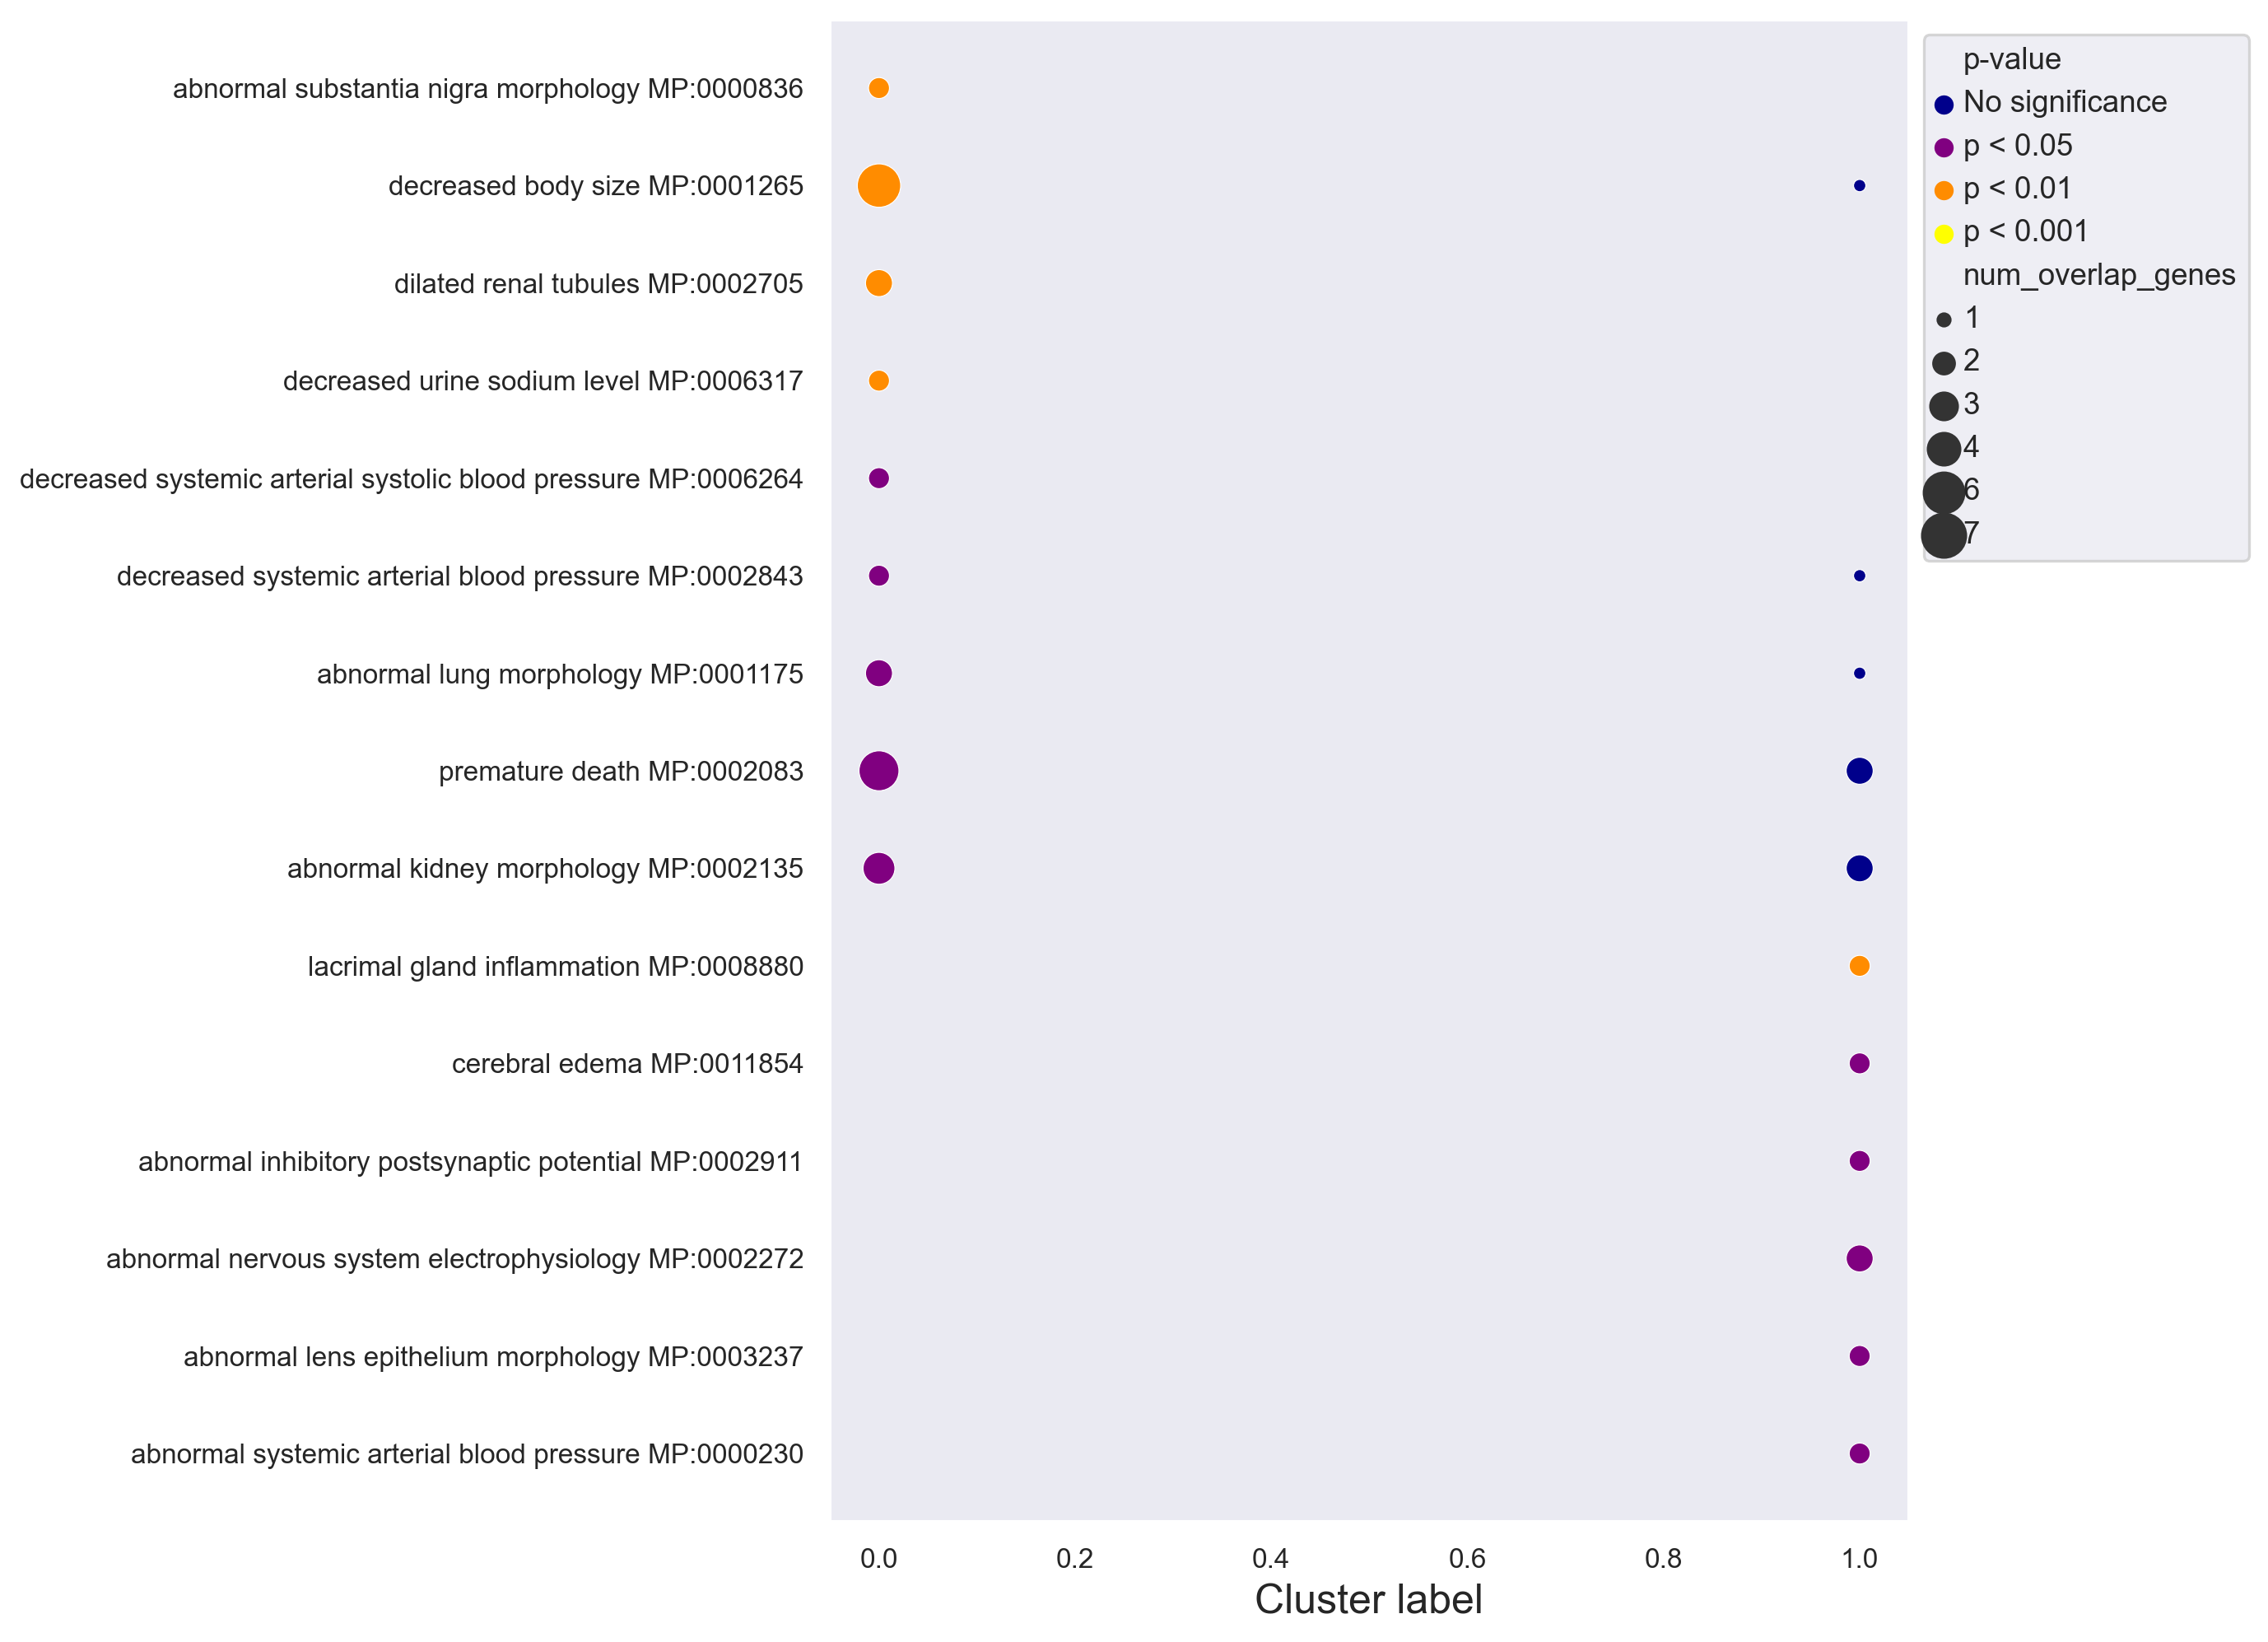

In [47]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [48]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [49]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Toxicity Of Botulinum Toxin Type D (botD) R-HSA-5250955,1,0.004123,510.444444,2802.970004,[SV2B],0.123683,0,0,1,0.907691,0
Toxicity Of Botulinum Toxin Type F (botF) R-HSA-5250981,2,0.004123,510.444444,2802.970004,[SV2B],0.123683,0,0,1,0.907691,0
Lewis Blood Group Biosynthesis R-HSA-9037629,3,0.012320,102.044444,448.641095,[B3GALT2],0.147841,0,0,1,0.830206,0
Blood Group Systems Biosynthesis R-HSA-9033658,4,0.012320,102.044444,448.641095,[B3GALT2],0.147841,0,0,1,0.830206,0
Neurotoxicity Of Clostridium Toxins R-HSA-168799,5,0.012320,102.044444,448.641095,[SV2B],0.147841,0,0,1,0.830206,0


In [50]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

9

In [51]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

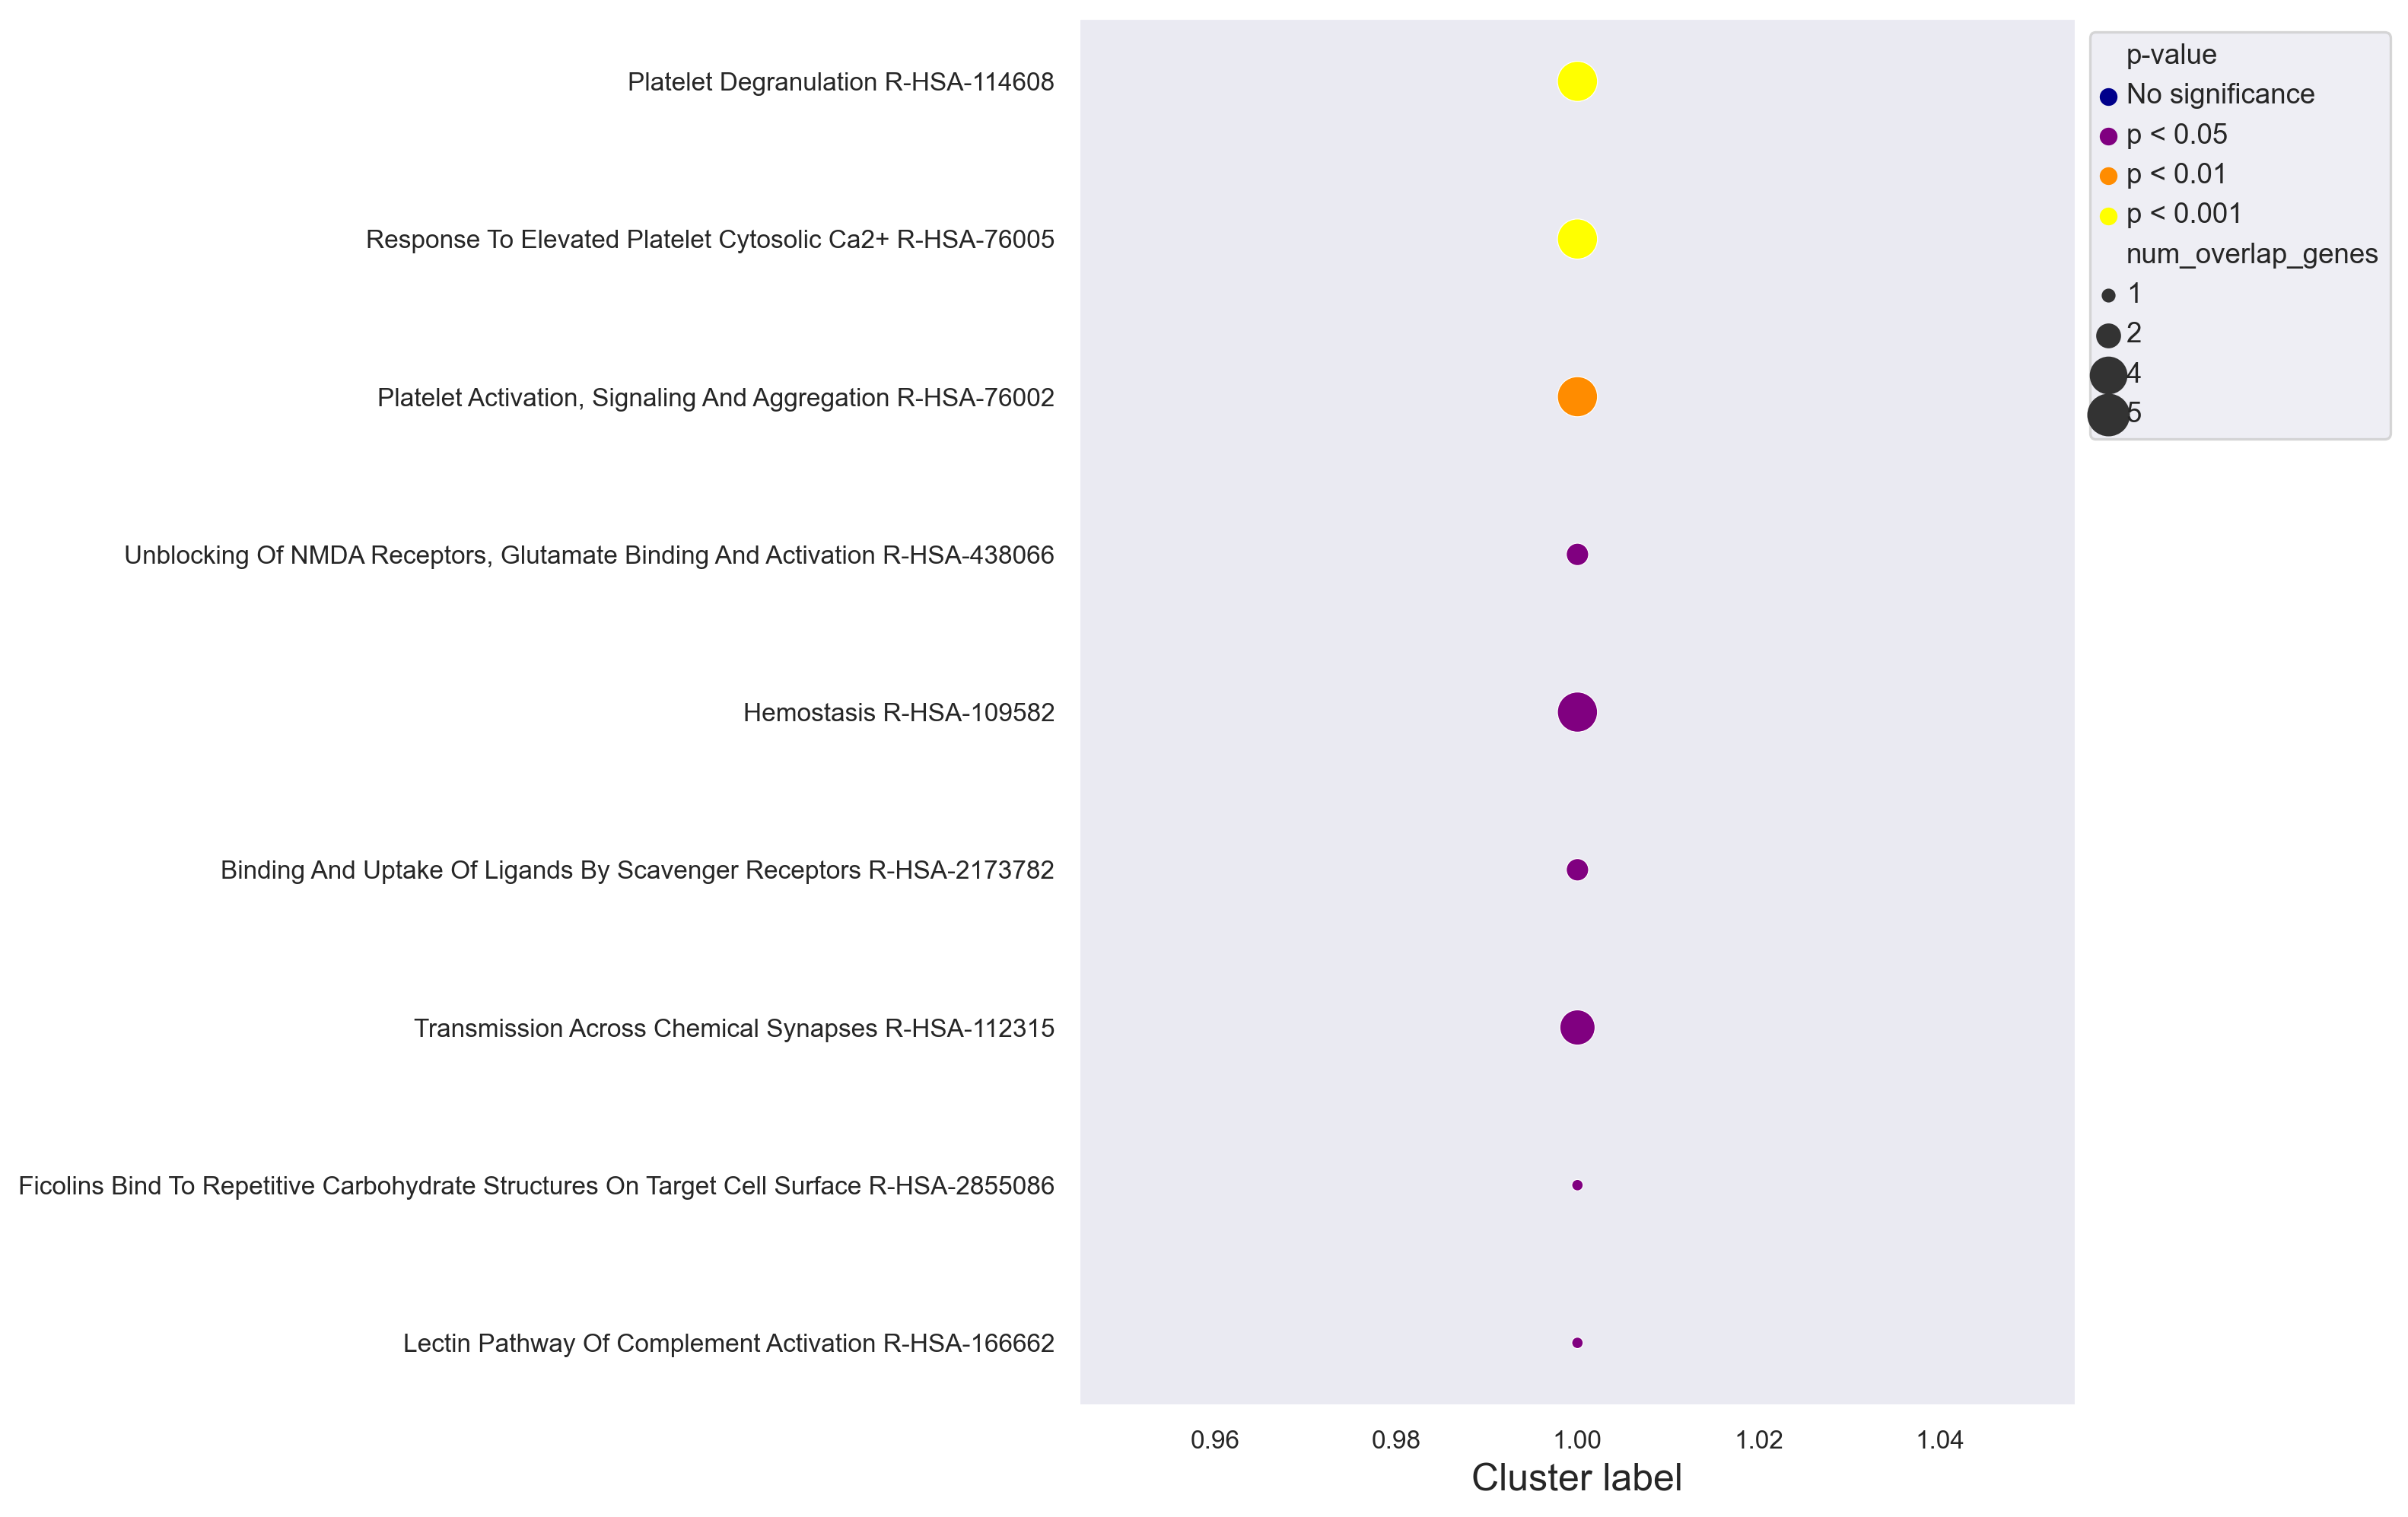

In [52]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [53]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [54]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
ECM-receptor interaction,1,0.001928,35.917647,224.524652,"[SV2B, SPP1]",0.073277,0,0,2,1.135033,0
Aldosterone synthesis and secretion,2,0.006225,19.186975,97.455345,"[NR4A2, AGT]",0.118268,0,0,2,0.927134,0
Renin-angiotensin system,3,0.018426,63.756944,254.644552,[AGT],0.233397,0,0,1,0.631905,0
Glycosphingolipid biosynthesis,4,0.046451,23.148990,71.052540,[B3GALT2],0.242934,0,0,1,0.614512,0
Renin secretion,5,0.066003,15.897569,43.210511,[AGT],0.242934,0,0,1,0.614512,0


In [58]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

0